In [1]:
# libraries
import sys 
sys.path.append("../models/")
from functions import compute_contacts, get_initial_conditions
from stochastic_SEIRD import simulate
from Basin import Basin
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt 

# n. of compartments and age groups
ncomp = 63
nage = 10

# fit dates
start_date = datetime(2020, 9, 1)
end_date = datetime(2021, 7, 5)

# Alpha increased transmissibility
psi = 0.5

# basins 
basins = ["northwest", "northeast", "center", "south", "sicily", "sardinia"]

def import_posterior(basin):
    # import data (params order: [R0, Delta, rnd_run, run_id, seasonality_min])
    return np.load("./posteriors/posterior_{0}.npz".format(basin))["arr_0"]

### Simulation Example (Fitted Model)

In [38]:
basin_name = "northwest"

# create Basin object
basin = Basin("Italy-" + basin_name, "../basins/", hemisphere=0)

# reported deaths 
real_deaths = basin.epi_data.loc[(basin.epi_data["Date"] >= datetime(2020, 9, 28)) &
                                 (basin.epi_data["Date"] < end_date)]["daily_Deaths"]

# pre-compute contacts matrices over time
Cs, dates = compute_contacts(basin, start_date, end_date)

# import posterior and sample random params 
posterior = import_posterior(basin_name)
params = posterior[np.random.randint(0, len(posterior))]

# simulate 
# parameters (R0, Delta, initial conditions, importations)
R0 = float(params[0])
Delta = int(params[1])
rnd_run = int(params[2])
run_id = int(params[3])
seasonality_min = float(params[4])

# get importations (random run)
imp_run = basin.importations[run_id]

# initial conditions
initial_conditions = get_initial_conditions(basin, rnd_run)

vaccinations = {"vaccinations_pfizer": basin.vaccinations_pfizer,
                "vaccinations_moderna": basin.vaccinations_moderna,
                "vaccinations_astrazeneca": basin.vaccinations_astrazeneca,
                "vaccinations_JJ": basin.vaccinations_JJ,
                "vaccinations_baseline_pfizer": basin.vaccinations_baseline_pfizer,
                "vaccinations_baseline_moderna": basin.vaccinations_baseline_moderna, 
                "vaccinations_baseline_astrazeneca": basin.vaccinations_baseline_astrazeneca,
                "vaccinations_baseline_JJ": basin.vaccinations_baseline_JJ}

# simulate with and without vaccine and resample deaths weekly
results_datadriven = simulate(Cs, psi, basin.Nk, initial_conditions, imp_run, vaccinations,
                              R0, Delta, dates, seasonality_min, basin.hemisphere, vaccine="data-driven")

results_false= simulate(Cs, psi, basin.Nk, initial_conditions, imp_run, vaccinations,
                        R0, Delta, dates, seasonality_min, basin.hemisphere, vaccine="False")

df_deaths = pd.DataFrame(data={"sim_deaths_data_driven": results_datadriven["deaths_TOT"].sum(axis=0)[27:],
                               "sim_deaths_false": results_false["deaths_TOT"].sum(axis=0)[27:], 
                               "real_deaths": real_deaths.values}, index=dates[27:])

df_deaths = df_deaths.resample("W").sum()


../models/stochastic_SEIRD.py:121: RuntimeWarning: invalid value encountered in true_divide
  ifr[age] = (deaths_WT[age] + deaths_VOC[age]) / (R_WT[age] + R_VOC[age] +
../models/stochastic_SEIRD.py:152: RuntimeWarning: invalid value encountered in true_divide
  ifr_tot = tot_deaths / tot_rec


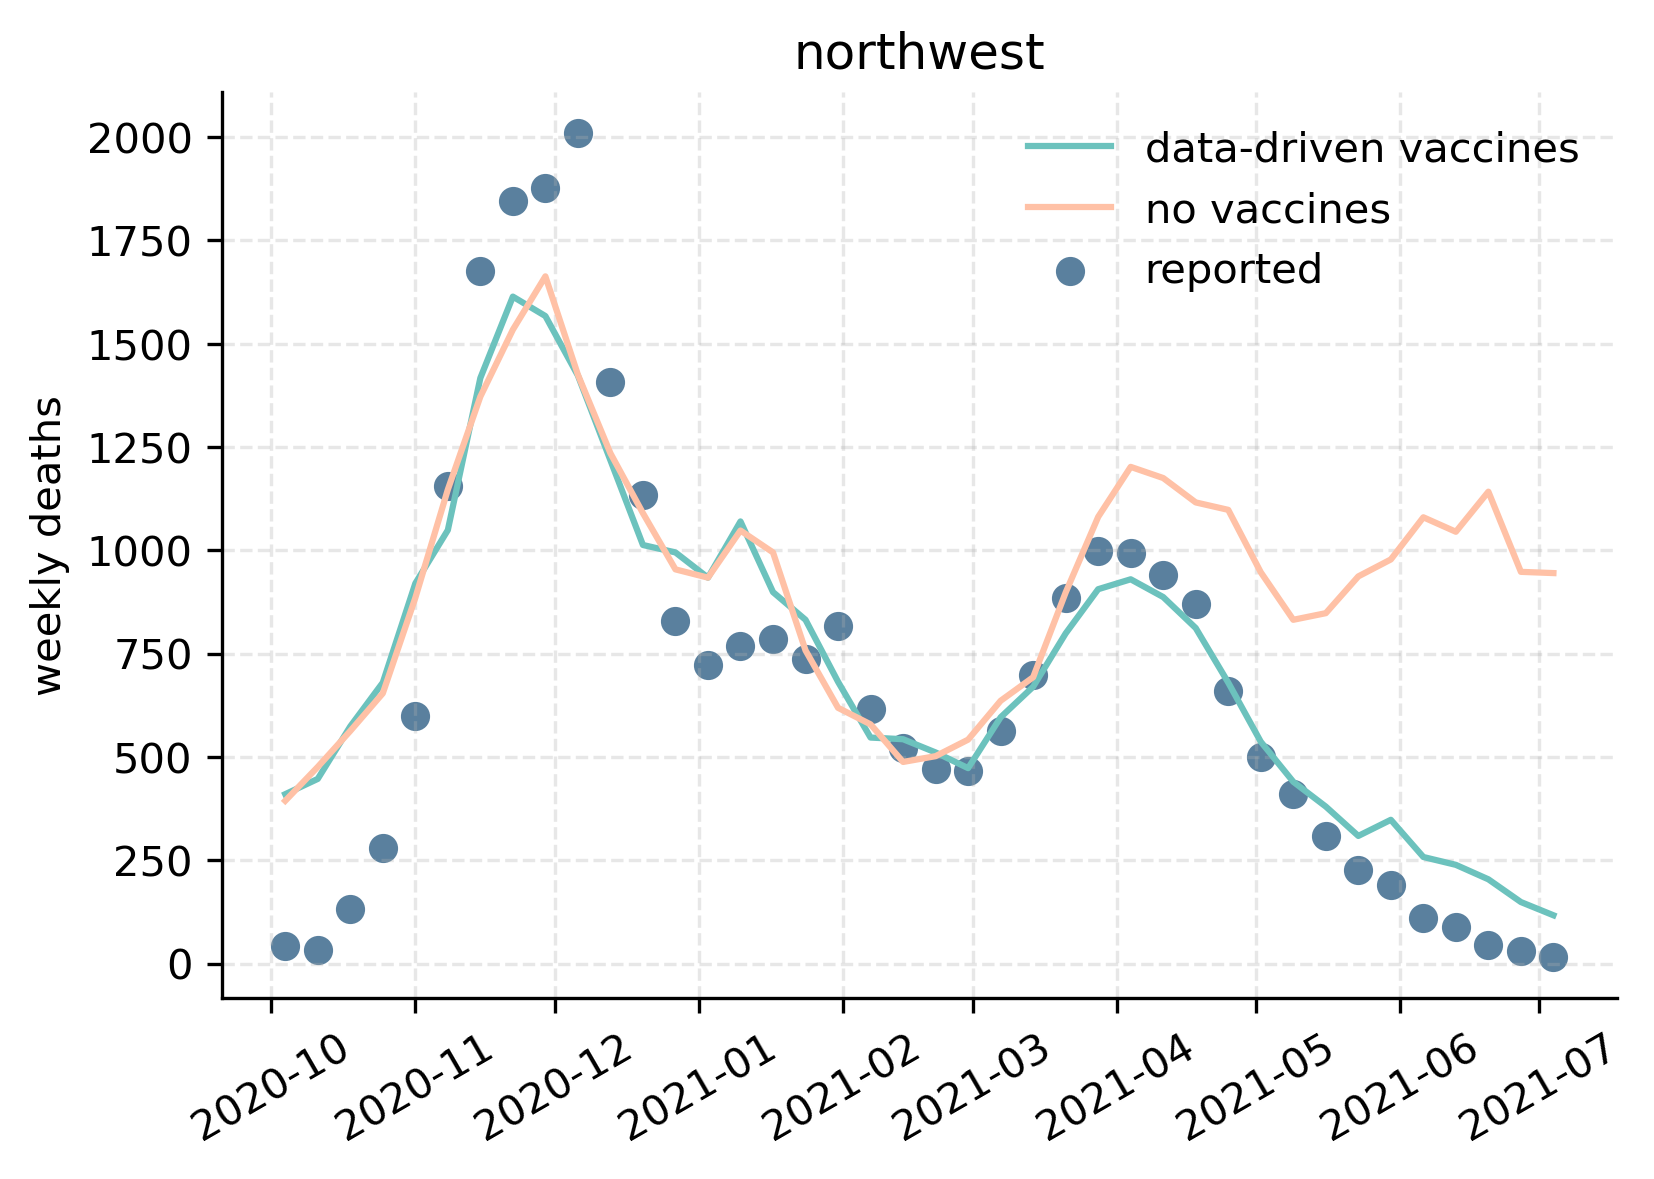

In [39]:
fig, ax = plt.subplots(dpi=300)

ax.plot(df_deaths.index, df_deaths.sim_deaths_data_driven.values, color="#6CC2BD", label="data-driven vaccines")
ax.plot(df_deaths.index, df_deaths.sim_deaths_false.values, color="#FFC1A6", label="no vaccines")
ax.scatter(df_deaths.index, df_deaths.real_deaths.values, color="#5A809E", label="reported")

ax.set_ylabel("weekly deaths")
ax.tick_params(axis="x", rotation=30)
ax.set_title(basin_name)
ax.legend(loc="upper right", frameon=False)
ax.grid(alpha=0.3, linestyle="--")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False);